In [3]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam #Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import itertools
import os
# import shutil
# import random
# import glob
import matplotlib.pyplot as plt

In [4]:
pwd

'/Users/stellato/Galvanize/capstone_2'

In [5]:
images_folder = 'images_tvt_split'
train_path = f'{images_folder}/train' 
valid_path = f'{images_folder}/valid'
test_path = f'{images_folder}/test'

In [6]:
#create keras image data generators for train, validate (valid), and holdout (test) sets. 
# Generates batches of feature augmented images from the generators, without having to actually create
# new images. Flows them through memory. 

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = train_path, target_size=(224,224), classes=['mask', 'no_mask'], batch_size=10) 

Found 536 images belonging to 2 classes.


In [8]:
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = valid_path, target_size=(224,224), classes=['mask', 'no_mask'], batch_size=10) 

Found 178 images belonging to 2 classes.


In [9]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = test_path, target_size=(224,224), classes=['mask', 'no_mask'], batch_size=10, shuffle=False) 

Found 178 images belonging to 2 classes.


In [10]:
# view the images generated from the data generators

In [11]:
# from src.plotting import showImages

In [12]:
# imgs, labels = next(train_batches)

In [13]:
# showImages(imgs, labels)


In [14]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [15]:
#vgg16_model.summary()
# ~130M trainable parameters

In [25]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [26]:
#model.summary()
# ~130M trainable parameters

In [27]:
#to stay below 4M trainable parameters, deactivate all layers except first 10 and 
#new last predictions layer (below)
for layer in model.layers[11:]:
    layer.trainable = False

In [28]:
# model.summary()
# ~2.915M trainable parameters

In [29]:
model.add(Dense(units=2, activation='softmax'))

In [30]:
model.summary()
# ~2.923M trainable parameters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 2,
                          restore_best_weights = True)

In [32]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=25, verbose=2, callbacks=[callback])

Epoch 1/25
54/54 - 645s - loss: 0.3790 - accuracy: 0.8563 - val_loss: 0.2259 - val_accuracy: 0.8933
Epoch 2/25
54/54 - 709s - loss: 0.2237 - accuracy: 0.9067 - val_loss: 0.1777 - val_accuracy: 0.9382
Epoch 3/25
54/54 - 694s - loss: 0.0961 - accuracy: 0.9720 - val_loss: 0.1108 - val_accuracy: 0.9607
Epoch 4/25
54/54 - 690s - loss: 0.0601 - accuracy: 0.9701 - val_loss: 0.1801 - val_accuracy: 0.9438
Epoch 5/25
54/54 - 670s - loss: 0.0471 - accuracy: 0.9795 - val_loss: 0.1197 - val_accuracy: 0.9551
Epoch 6/25
54/54 - 698s - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0902 - val_accuracy: 0.9663
Epoch 7/25
54/54 - 805s - loss: 0.0322 - accuracy: 0.9888 - val_loss: 0.1742 - val_accuracy: 0.9438
Epoch 8/25
54/54 - 816s - loss: 0.0663 - accuracy: 0.9813 - val_loss: 0.1623 - val_accuracy: 0.9551
Epoch 9/25
54/54 - 857s - loss: 0.0675 - accuracy: 0.9739 - val_loss: 0.2060 - val_accuracy: 0.9213
Epoch 10/25
54/54 - 843s - loss: 0.0280 - accuracy: 0.9888 - val_loss: 0.1229 - val_accuracy: 0.9551

In [33]:
model.save(f'./vgg16_model_longrun2')

INFO:tensorflow:Assets written to: ./vgg16_model_longrun2/assets


In [34]:
# test_imgs, test_labels = next(test_batches)
# showImages(test_imgs, test_labels)

In [35]:
#custom vgg16
model.evaluate(test_batches, verbose=True)

 8/18 [============>.................] - ETA: 39s - loss: 0.1221 - accuracy: 0.9500

/Users/stellato/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


18/18 [==============================] - 73s 4s/step - loss: 0.1271 - accuracy: 0.9607


[0.12713226675987244, 0.9606741666793823]

In [36]:
predictions = model.predict(x=test_batches, verbose=0)

In [37]:
predictions =  np.round(predictions)

In [38]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['mask', 'no_mask']

In [39]:
from src.plotting import plot_confusion_matrix

Confusion matrix without normalization
[[93  4]
 [ 3 78]]


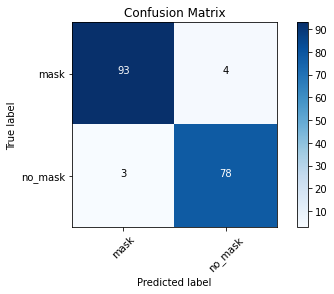

In [40]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [50]:
pwd

'/Users/stellato/Galvanize/capstone_2'

In [65]:
from tensorflow.keras.preprocessing import image

img_path = 'sub_images/maksssksksss6.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_batch)
input_prediction = model.predict(img_preprocessed)
input_prediction = np.round(input_prediction[0])[0]

In [66]:
input_prediction

1.0

In [89]:
from src.plotting import *

In [91]:
show_single

NameError: name 'show_single' is not defined

In [98]:
def temp_show_single(image_path, label):
    if label == 1:
        label = 'mask'
    else: 
        label = 'no mask'
        
    fig, ax = plt.subplots(figsize=(10,10))
    image = plt.imread(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(label)
    plt.tight_layout()
    plt.show()

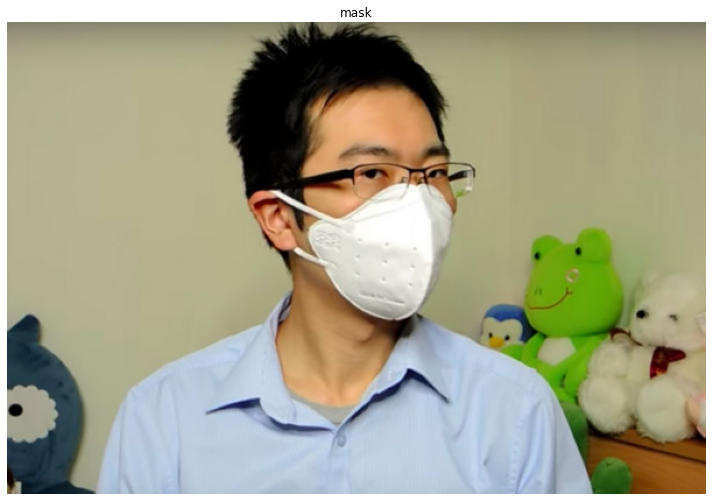

In [99]:
temp_show_single(img_path, input_prediction)

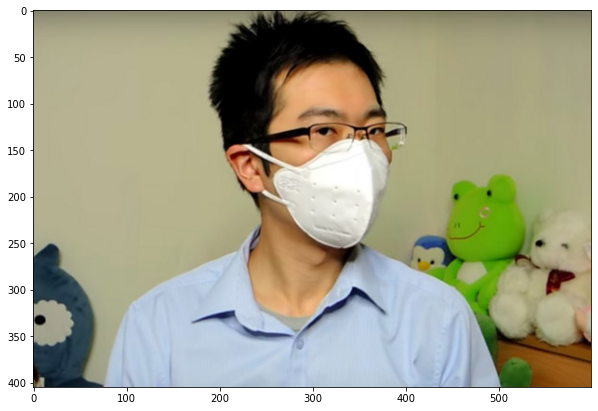

In [97]:
fig, ax = plt.subplots(figsize=(10,10))
temp = plt.imread('sub_images/maksssksksss6.png')
ax.imshow(temp)

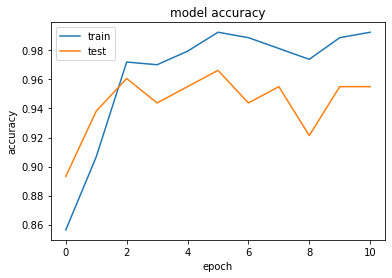

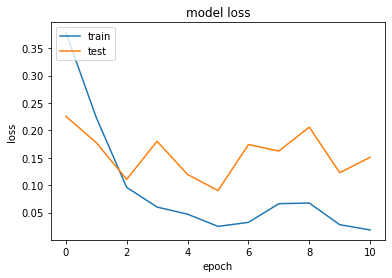

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()